# Train YOLOv2 model

This notebook contains code for training the YOLOv2 model either on the PascalVOC or the COCO dataset.

Before training, make sure that the data has been downloaded to the relevant directories and these are passed to the `ImageReader` classes below. The [weights for Darknet](https://pjreddie.com/darknet/yolo/) also need to be downloaded with
 
```
!wget https://pjreddie.com/media/files/yolov2.weights
```

### Import relevant Python modules

In [7]:
import os
use_CPU = False
if use_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from darknet import Darknet19
from loss_function import YOLOv2Loss
from image_reader import COCOImageReader, PascalVOCImageReader
from data_generator import DataGeneratorFactory
from loss_function import YOLOv2Loss

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

np.random.seed(231417)

device_names = tf.config.list_physical_devices()

print (device_names)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare data structures

In [8]:
use_coco = False

if use_coco:
    train_image_reader = COCOImageReader(data_dir="../../../cocodata/",data_type = "train2017",image_size=416,n_tiles=13)
    validation_image_reader = COCOImageReader(data_dir="../../../cocodata/",data_type = "val2017",image_size=416,n_tiles=13)
    anchor_boxes_filename = "anchor_boxes_coco.json"
else:
    train_image_reader = PascalVOCImageReader(data_dir="../../../pascalvocdata/VOC2012/",data_type="train",image_size=416,n_tiles=13)
    validation_image_reader = PascalVOCImageReader(data_dir="../../../pascalvocdata/VOC2012/",data_type="val",image_size=416,n_tiles=13)
    anchor_boxes_filename = "anchor_boxes_pascalvoc.json"

# Read anchor boxes from json file
with open(anchor_boxes_filename, "r", encoding="utf8") as f:
            anchor_boxes = json.load(f)


train_data_generator = DataGeneratorFactory(anchor_boxes, train_image_reader,random_shuffle=True,max_images=None)
validation_data_generator = DataGeneratorFactory(anchor_boxes, validation_image_reader,random_shuffle=True,max_images=None)

BATCH_SIZE = 8
BBOX_CACHE_SIZE = 4
N_EPOCHS = 20
N_TRAIN_SAMPLES = train_image_reader.get_n_images()
N_VALIDATION_SAMPLES = validation_image_reader.get_n_images()
VALIDATION_SUBSPLITS = 1
STEPS_PER_EPOCH = N_TRAIN_SAMPLES // BATCH_SIZE
VALIDATION_STEPS= N_VALIDATION_SAMPLES // BATCH_SIZE // VALIDATION_SUBSPLITS

print (f'number of training samples = {N_TRAIN_SAMPLES:d}')
print (f'steps per epoch = {STEPS_PER_EPOCH:d}')
print (f'number of validation samples = {N_VALIDATION_SAMPLES:d}')
train_batches = train_data_generator.dataset.batch(BATCH_SIZE,drop_remainder=True)
validation_batches = validation_data_generator.dataset.batch(BATCH_SIZE,drop_remainder=True)

# Checkpoints
log_dir = './tb_logs/'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir)

checkpoint_dir='./model_checkpoint/'
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=False,
    save_freq='epoch')


number of classes = 20
number of classes = 20
number of training samples = 11987
steps per epoch = 1498
number of validation samples = 3425


### Train model
The actual training happens here.

In [ ]:

# Set this to True to continue training from an already saved model
load_model = True
# Set this to True to save model weights to disk
save_model = True
# Name of directory to which to read/write model
saved_model_dir = "saved_model"

if load_model:
    # Load saved model from disk
    model = tf.keras.models.load_model(saved_model_dir,custom_objects={'YOLOv2Loss':YOLOv2Loss})
else:
    # Start training from scratch
    darknet = Darknet19(416, 13, 5, train_image_reader.n_classes)
    model = darknet.model
    yolov2_loss = YOLOv2Loss(anchor_boxes=anchor_boxes,bbox_cachesize=BBOX_CACHE_SIZE)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.5E-4,beta_1=0.9,beta_2=0.999, epsilon=1.E-8, decay=0.0)
    model.compile(loss=yolov2_loss,optimizer=optimizer)

model.fit(train_batches,epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=validation_batches,
          callbacks=[model_checkpoint_cb,tensorboard_cb])
if save_model:
    model.save(saved_model_dir)

## Loss curve

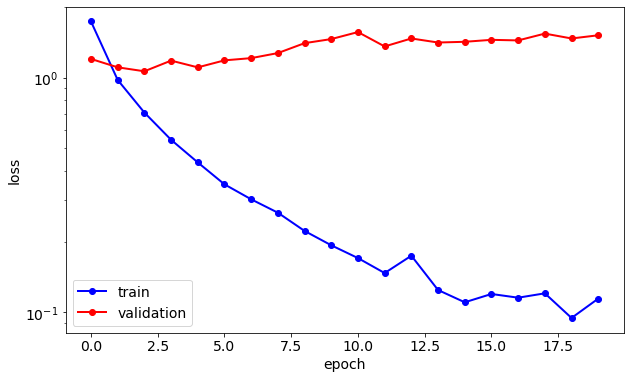

In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update({'font.size': 14})

plt.figure(figsize=(10,6))
color={"train":"blue","validation":"red"}
for data_type in "train", "validation":
    data_file = f"../assets/{data_type}.csv"
    data = pd.read_csv(data_file)
    steps = data["Step"].to_numpy()
    loss = data["Value"].to_numpy()    
    ax = plt.gca()
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_yscale("log")
    plt.plot(steps,loss,
             linewidth=2,color=color[data_type],
             markersize=6,
             marker='o',
             label=data_type)
    plt.legend(loc="lower left")